In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

import random
import math
import networkx as nx

import boto3
from PIL import Image

import requests
import json

from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear()  # ⬅ add this line

%matplotlib inline

plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)

In [3]:
import pickle # save images
import time # get time stamp of models trained

## Import text files (image names, labels)

In [4]:
import matplotlib.image as mpimg # show images
from io import BytesIO # reading bytes

#### Create dataframe with images.txt

_Contains name of images and file path_  
- Split into file path, image name, and folder number

In [5]:
bucket = 'cwbirdsimages'

In [6]:
s3 = boto3.client('s3')
img_txt = s3.get_object(Bucket=bucket, Key='images.txt')

img_names = BytesIO(img_txt['Body'].read())

In [7]:
img_data = pd.read_csv(img_names, header=None, low_memory=False, na_values='n/a')

In [8]:
img_data['file_path'] = img_data[0].apply(lambda x: x.split()[1])
img_data['img_name'] = img_data[0].apply(lambda x: x.split()[0])

img_data['class_id'] = img_data['file_path'].apply(lambda x: x.split('/')[0])

In [9]:
img_data.drop(0, axis=1, inplace=True)

In [10]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48562 entries, 0 to 48561
Data columns (total 3 columns):
file_path    48562 non-null object
img_name     48562 non-null object
class_id     48562 non-null object
dtypes: object(3)
memory usage: 1.1+ MB


In [11]:
# 'class_id' should be int
img_data['class_id'] = img_data['class_id'].apply(lambda x: int(x))

#### Create dataframe of image_class_labels.txt

_Contains name of image file and corresponding folder number_  
- Split into image name, and folder number

In [12]:
s3 = boto3.client('s3')
img_class = s3.get_object(Bucket=bucket, Key='image_class_labels.txt')

img_class_labels = BytesIO(img_class['Body'].read())

In [13]:
labels_df = pd.read_csv(img_class_labels, header=None, low_memory=False, na_values='n/a')

In [14]:
labels_df

,0
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829 817
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b 860
2,00019306-9d83-4334-b255-a447742edce3 900
3,0001afd4-99a1-4a67-b940-d419413e23b3 645
4,000332b8-997c-4540-9647-2f0a8495aecf 929
5,000343bd-5215-49ba-ab9c-7c97a70ac1a5 652
6,0004ff8d-0cc8-47ee-94ba-43352a8b9eb4 951
7,0007181f-a727-4481-ad89-591200c61b9d 900
8,00071e20-8156-4bd8-b5ca-6445c2560ee5 988
9,0007acfc-c0e6-4393-9ab6-02215a82ef63 400


In [15]:
labels_df['img_name'] = labels_df[0].apply(lambda x: x.split()[0])
labels_df['class_id'] = labels_df[0].apply(lambda x: x.split()[1])

In [16]:
labels_df.drop(0, axis=1, inplace=True)

In [17]:
labels_df

,img_name,class_id
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,817
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,860
2,00019306-9d83-4334-b255-a447742edce3,900
3,0001afd4-99a1-4a67-b940-d419413e23b3,645
4,000332b8-997c-4540-9647-2f0a8495aecf,929
5,000343bd-5215-49ba-ab9c-7c97a70ac1a5,652
6,0004ff8d-0cc8-47ee-94ba-43352a8b9eb4,951
7,0007181f-a727-4481-ad89-591200c61b9d,900
8,00071e20-8156-4bd8-b5ca-6445c2560ee5,988
9,0007acfc-c0e6-4393-9ab6-02215a82ef63,400


In [17]:
# 'class_id' should be int
labels_df['class_id'] = labels_df['class_id'].apply(lambda x: int(x))

In [18]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48562 entries, 0 to 48561
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_name  48562 non-null  object
 1   class_id  48562 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 758.9+ KB


#### Create dataframe with hierarchy.txt

_Contains folder number and class number_  
- Split into folder number and class number

In [23]:
# s3 = boto3.client('s3')
# hierarchy_txt = s3.get_object(Bucket=bucket, Key='hierarchy.txt')

# hierarchy = BytesIO(hierarchy_txt['Body'].read())

# hier_df = pd.read_csv(hierarchy, header=None, low_memory=False, na_values='n/a')

# hier_df.head()

In [26]:
# hier_df['folder_num'] = hier_df[0].apply(lambda x: x.split()[0])
# hier_df['class_id'] = hier_df[0].apply(lambda x: x.split()[1])

# hier_df.drop(0, axis=1, inplace=True)

# hier_df

#### Create dataframe with classes.txt

_Contains class number and class labels_  
- Split into class number and class labels_

In [18]:
s3 = boto3.client('s3')
classes_txt = s3.get_object(Bucket=bucket, Key='classes.txt')

classes = BytesIO(classes_txt['Body'].read())

In [19]:
classes_df = pd.read_csv(classes, sep='\t', header=None, low_memory=False, na_values='n/a')

In [20]:
classes_df.head()

,0
0,0 Birds
1,"1 Ducks, Geese, and Swans"
2,"2 Grouse, Quail, and Allies"
3,3 Loons
4,4 Grebes


In [21]:
classes_df['class_id'] = classes_df[0].apply(lambda x: x.split(' ', 1)[0])
classes_df['txt_labels'] = classes_df[0].apply(lambda x: x.split(' ', 1)[1])

In [22]:
classes_df.drop(0, axis=1, inplace=True)

In [23]:
# 'class_id' should be int
classes_df['class_id'] = classes_df['class_id'].apply(lambda x: int(x))

## Merge all dataframes

The folder numbers corresponds to the class ids
merge the **img_data** dataframe (containing file path, image name, and class id) and the **classes_df** dataframe (class id and txt_labels)

In [24]:
master_df = img_data.merge(classes_df, on='class_id')

In [25]:
master_df[master_df['class_id']==565]

,file_path,img_name,class_id,txt_labels


In [26]:
master_df.shape

(48562, 4)

In [27]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48562 entries, 0 to 48561
Data columns (total 4 columns):
file_path     48562 non-null object
img_name      48562 non-null object
class_id      48562 non-null int64
txt_labels    48562 non-null object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [29]:
pd.set_option('display.max_rows', 100)

master_df.head(10)

,file_path,img_name,class_id,txt_labels
0,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0000139e-21dc-4d0c-bfe1-4cae3c85c829,817,Oak Titmouse
1,0817/01a472d8e93047a080aae4f958a2ef47.jpg,01a472d8-e930-47a0-80aa-e4f958a2ef47,817,Oak Titmouse
2,0817/036fba7c96374635853511ead2c1c728.jpg,036fba7c-9637-4635-8535-11ead2c1c728,817,Oak Titmouse
3,0817/07814887f59b44cb9b7f399999634fba.jpg,07814887-f59b-44cb-9b7f-399999634fba,817,Oak Titmouse
4,0817/0822865741de43128a6a6c8897387975.jpg,08228657-41de-4312-8a6a-6c8897387975,817,Oak Titmouse
5,0817/0b277615eb6e499da2fc26525aa6e60e.jpg,0b277615-eb6e-499d-a2fc-26525aa6e60e,817,Oak Titmouse
6,0817/110f7a2a05cd488fb15425588f75b80e.jpg,110f7a2a-05cd-488f-b154-25588f75b80e,817,Oak Titmouse
7,0817/148631327cc44e1caebe38671d1b54c0.jpg,14863132-7cc4-4e1c-aebe-38671d1b54c0,817,Oak Titmouse
8,0817/15118d82ede04508b25309ea9854a659.jpg,15118d82-ede0-4508-b253-09ea9854a659,817,Oak Titmouse
9,0817/16da4080692342d28d3fa9328cab8c0a.jpg,16da4080-6923-42d2-8d3f-a9328cab8c0a,817,Oak Titmouse


In [32]:
# master_df.to_csv('data/master_df.csv')

In [33]:
master_df['txt_labels'].nunique()

555

In [41]:
master_df['class_id'].nunique()

555

In [42]:
master_df.groupby('class_id').count()

,file_path,img_name,txt_labels
class_id,,,
295,53,53,53
296,64,64,64
297,87,87,87
298,67,67,67
299,120,120,120
313,47,47,47
314,120,120,120
315,116,116,116
316,96,96,96


## Import images

In [38]:
len(master_df['file_path'])

48562

In [37]:
# grab and resize image from and to s3 bucket

img_dir = 'images' # folder containing all other folders of images
paths = master_df['file_path']

def resize_images_array(img_dir, file_paths):
    # arrays of image pixels
    img_arrays = []
    
    # loop through the dataframe that is linked to its label so that all images are in the same order
    for path in tqdm(file_paths):
        s3 = boto3.client('s3')
        try:
            obj = s3.get_object(Bucket=bucket, Key=f'{img_dir}/{path}')
            img_bytes = BytesIO(obj['Body'].read())
            open_img = Image.open(img_bytes)
            arr = np.array(open_img.resize((299,299))) # resize to 200,200. possible to play around with better or worse resolution
            img_arrays.append(arr)
        except:
#             print(path) # get file_path of ones that fail to load
            continue

    return np.array(img_arrays)

In [42]:
# s3 = boto3.client('s3')
# obj = s3.get_object(Bucket=bucket, Key=f'images/0817/0000139e21dc4d0cbfe14cae3c85c829.jpg')
# img_bytes = BytesIO(obj['Body'].read())
# open_img = Image.open(img_bytes)
# arr = np.array(open_img.resize((200,200))) # resize to 200,200. possible to play around with better or worse resolution
# s3.upload_file(arr, 'cwbirdsimages', 'resized_images/0817/0000139e21dc4d0cbfe14cae3c85c829.jpg')

##### final data grab amount

In [36]:
X = resize_images_array(img_dir, master_df['file_path'])

 22%|██▏       | 10655/48562 [23:46<1:24:36,  7.47it/s]


KeyboardInterrupt: 

##### small sample len and shape

In [86]:
# sm_samp = resize_images_array(img_dir, master_df['file_path'][:3098])

100%|██████████| 3098/3098 [06:21<00:00,  8.12it/s]


In [90]:
print('length of sample: ', len(X))
X.shape

length of small sample:  3098


(3098, 200, 200, 3)

#### Show the 3 channels of colors

In [154]:
single_img = master_df['file_path'][985]
single_img

'0776/16398b734cf540e3b0bcc943621e3515.jpg'

In [155]:
obj = s3.get_object(Bucket=bucket, Key=f'images/0776/16398b734cf540e3b0bcc943621e3515.jpg')
img_bytes = BytesIO(obj['Body'].read())
open_img = Image.open(img_bytes)

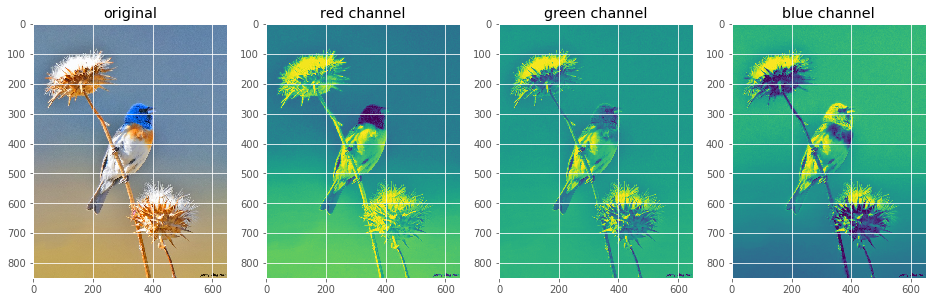

In [156]:
# By stacking these together into a 3-tensor, we can represent a color image as a single object.

fig, axes = plt.subplots(1, 4, figsize=(16,6))

axes[0].imshow(open_img)
axes[0].set_title('original')
for ax, channel, name in zip(axes[1:], open_img.split(), ['red channel', 'green channel', 'blue channel']):
    ax.imshow(channel)
    ax.set_title(name)

### Create labels and features arrays and normalize features arrays

##### small sample normalize

In [37]:
# normalize the RBG values
X = X/255.0

In [38]:
# test = X.copy()

# from tensorflow.keras.utils import normalize

# backup = pd.HDFStore('backup.h5')

# backup['X'] = pd.Series(X)

# DONT FORGET TO CHANGE RANGE HERE TOO

In [39]:
# grab numeric label
# VALUES MUST BE NP.ARRAYS

label = np.array(master_df['class_id'].values)

##### y labels need to be one hot encoded

In [40]:
y = (label.reshape(-1,1) == master_df['class_id'].unique()).astype(float)

In [41]:
print('label shape: ', y.shape)
print('features shape: ', X.shape)

label shape:  (20047, 214)
features shape:  (20047, 200, 200, 3)


In [42]:
master_df['class_id'].unique()

array([ 817,  860,  900,  645,  929,  652,  951,  988,  400,  845,  698,
        776,  651,  700,  947,  555,  380,  945,  797,  816,  985,  349,
        949,  963,  821,  504,  997,  351,  667,  629,  661,  943,  528,
        537,  766,  760,  811,  861,  656,  840,  888,  479,  753,  922,
        453,  638,  481,  854,  323,  927,  324,  526,  757,  541,  469,
        534,  335,  910,  767,  376,  789, 1005,  998,  628,  533,  506,
        605,  932,  477,  994,  948,  764,  832,  903,  815,  962,  299,
        857,  810,  851,  849,  362,  498,  316,  899,  535,  517,  967,
        790,  779,  912,  780,  636,  850,  511,  364,  979,  884,  546,
        539,  788,  500,  557,  835,  341,  338,  761,  897,  901,  679,
        499,  908,  536,  960,  798,  379,  756,  926,  880,  468,  373,
        862,  489,  916,  825,  833,  492,  369,  906,  599,  784,  393,
        747,  644,  804,  448,  549,  883,  543,  398,  952,  937,  348,
        395,  946,  604,  509,  978,  466,  783,  6

In [63]:
y[115]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Machine Learning Libraries Import

In [47]:
# from sklearn.ensemble import RandomForestClassifier

## Random Forest Classifier

In [256]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split

# sample = np.array([x.flatten() for x in xs_samp])
# sample.shape

In [257]:
# clf = RandomForestClassifier(n_jobs=-1)

# X_train, X_test, y_train, y_test = train_test_split(sample, y, test_size=0.2, random_state=42)

# print("Train model")
# clf.fit(X_train, y_train)

# print("Predictions")
# predicted = clf.predict(X_test)

# # there are too many labels

# print("Accuracy: ", accuracy_score(y_test, predicted))

## Train Test Split

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization # CNN
from tensorflow.keras.models import Model

from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop

from tensorflow.keras.callbacks import TensorBoard # graphical visual of loss and accuracy over the epochs of train and test set
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import datetime

tf.__version__

Oak Titmouse


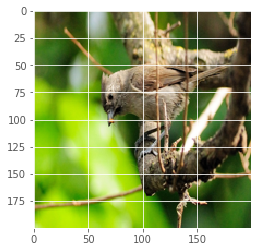

In [47]:
# check to make sure the bird images and labels are aligned
# this is indeed a semipalmated sandpiper

print(master_df.iloc[57, :]['txt_labels'])
plt.imshow(X[57]);

1. X, and y defined
- make sure they are arrays!!

2. normalize X values by dividing by 255
3. check images
4. train test split
5. make model Sequential()
6. add input layer
7. add multiple hidden layers
8. ADD FLATTEN LAYER, MUST BE BEFORE OUTPUT
9. add dense layer, which are fully connected layers
10. add output dense layer, will be the amount of labels there are
11. model.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
12. model.fit(xtrain, ytrain, epochs) also has validation_split (out of sample) do about 0.1, batchsize: how many at a time, more data requires bigger (20-200 range)
13. model.evaluate(xtest,ytest) returns val loss and val accuracy  

14. model.save('name') saves the model
- to load: new_model = tf.keras.models.load_model('name')

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

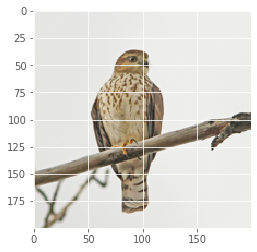

In [51]:
plt.imshow(X_train[55]);

In [52]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (16037, 200, 200, 3)
X_test shape:  (4010, 200, 200, 3)
y_train shape:  (16037, 214)
y_test shape:  (4010, 214)


## TRANSFER LEARNING MODEL

In [ ]:
log_xcept = os.path.join("logs/large_xception", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_xcept, histogram_freq=1)

In [ ]:
input_size = (299,299,3)
model = Xception(weights='imagenet',
                          include_top=True,
                          input_shape=input_size)

In [ ]:
# def print_model_properties(model, indices = 0):
#      for i, layer in enumerate(model.layers[indices:]):
#         print(f"Layer {i+indices} | Name: {layer.name} | Trainable: {layer.trainable}")

# print_model_properties(model)

In [ ]:
def create_transfer_model(input_size, n_categories, weights = 'imagenet'):
        # note that the "top" is not included in the weights below
        base_model = Xception(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        model = GlobalAveragePooling2D()(model)
        predictions = Dense(n_categories, activation='softmax')(model)
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model

In [ ]:
transfer_model = create_transfer_model((299,299,3),555)

In [ ]:
def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True

In [ ]:
_ = change_trainable_layers(transfer_model, 132)

In [ ]:
print_model_properties(transfer_model, 130)

In [ ]:
transfer_model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
xception_final = transfer_model.fit(X, y, batch_size=1000, epochs=5, validation_split=0.1)

In [ ]:
transfer_model.save('saved_models/large_xception.h5')
# load_L_xception = tf.keras.models.load_model('saved_models/large_xception.h5')

In [ ]:
# transfer_test = transfer_model.fit(X_train, y_train, batch_size = 32, epochs=5, validation_split=0.1)

In [ ]:
# print('Transfer Model1: Loss and Accuracy')
# evaluate = transfer_model.evaluate(X_test, y_test)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

pred1 = transfer_model.predict(X_test)

y_true = y_test.copy()

y_true = np.array([i.argmax() for i in y_true]).reshape(-1,1)

y_predicted = (pred1 > 0.5).astype(float)

y_predicted = np.array([i.argmax() for i in y_predicted]).reshape(-1,1)

mat = confusion_matrix(y_true, y_predicted)

plot_confusion_matrix(conf_mat=mat, figsize=(8,8), class_names=folders);

## Neural Network Model 0

In [53]:
model = Sequential()

model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax')) # have to have same amount as y_train.shape[1]

In [54]:
print('Model 0: Baseline Model NN')
print(f'Number of Training Images: {X_train.shape[0]}/{X_train.shape[0] + X_test.shape[0]}')
model.summary()

Model 0: Baseline Model NN
Number of Training Images: 16037/20047
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 120000)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               15360128  
_________________________________________________________________
dense_1 (Dense)              (None, 214)               27606     
Total params: 15,387,734
Trainable params: 15,387,734
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [56]:
print('Model 0: Baseline Model NN')
print(f'Number of Training Images: {X_train.shape[0]}/{X_train.shape[0] + X_test.shape[0]}')
history = model.fit(X_train, y_train, epochs=5, validation_split=0.1)

Model 0: Baseline Model NN
Number of Training Images: 16037/20047
Epoch 1/5
452/452 [==============================] - 17s 39ms/step - loss: 6.5630 - accuracy: 0.0058 - val_loss: 5.3563 - val_accuracy: 0.0025
Epoch 2/5
452/452 [==============================] - 18s 39ms/step - loss: 5.3516 - accuracy: 0.0067 - val_loss: 5.3577 - val_accuracy: 0.0025
Epoch 3/5
452/452 [==============================] - 17s 38ms/step - loss: 5.3451 - accuracy: 0.0070 - val_loss: 5.3462 - val_accuracy: 0.0025
Epoch 4/5
452/452 [==============================] - 17s 37ms/step - loss: 5.3402 - accuracy: 0.0070 - val_loss: 5.3436 - val_accuracy: 0.0025
Epoch 5/5
452/452 [==============================] - 17s 38ms/step - loss: 5.3372 - accuracy: 0.0070 - val_loss: 5.3419 - val_accuracy: 0.0025


In [57]:
test_loss, test_acc = model.evaluate(X_test, y_test)

126/126 [==============================] - 1s 8ms/step - loss: 5.3381 - accuracy: 0.0030


In [58]:
pred = model.predict(X_test)

In [71]:
print('Weak Model Prediction Check: ')
print('True label of bird: ', y_train[0].argmax(),classes_df.loc[379][['class_id', 'txt_labels']].values)
print('Predicted label of bird: ', pred[0].argmax(), classes_df.loc[458][['class_id', 'txt_labels']].values)

Weak Model Prediction Check: 
True label of bird:  115 [379 'Rufous Hummingbird (Adult Male)']
Predicted label of bird:  201 [458 'Mute Swan']


In [67]:
pred[0].argmax()

201

In [68]:
master_df.iloc[:20047, :]['class_id'].unique()[201]

458

## CNN: Convolutional Neural Network Model 1

In [72]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (16037, 200, 200, 3)
X_test shape:  (4010, 200, 200, 3)
y_train shape:  (16037, 214)
y_test shape:  (4010, 214)


In [73]:
# Create model
model1 = Sequential()

# Convolution Layer
model1.add(Conv2D(32, (3,3), activation='relu', input_shape=X_train[0].shape)) # scans with a (3,3) grid
model1.add(BatchNormalization())
model1.add(MaxPool2D(2,2)) # grid to pool together the first grid
model1.add(Dropout(0.3))

model1.add(Conv2D(64, (3,3), activation='relu')) # scans with a (3,3) grid
model1.add(BatchNormalization())
model1.add(MaxPool2D(2,2)) # grid to pool together the first grid
model1.add(Dropout(0.3))

model1.add(Conv2D(128, (3,3), activation='relu')) # scans with a (3,3) grid
model1.add(BatchNormalization())
model1.add(MaxPool2D(2,2)) # grid to pool together the first grid
model1.add(Dropout(0.4))

# Must Flatten before entering Dense layers
model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

model1.add(Dense(y_train.shape[1], activation='softmax')) # have to have same amount as y_train.shape[1]

In [74]:
print('Model 1: CNN')
print(f'Number of Training Images: {X_train.shape[0]}/{X_train.shape[0] + X_test.shape[0]}')
model1.summary()

Model 1: CNN
Number of Training Images: 16037/20047
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 97, 97, 64)        256       
_________________________________________________________________
ma

In [75]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
log_dir = os.path.join("logs/fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [77]:
print('Model 1: CNN')
print(f'Number of Training Images: {X_train.shape[0]}/{X_train.shape[0] + X_test.shape[0]}')
history1 = model1.fit(X_train, y_train, batch_size = 100, epochs=10, validation_split=0.1, callbacks=[tensorboard_callback])

Model 1: CNN
Number of Training Images: 16037/20047
Epoch 1/10
452/452 [==============================] - 375s 830ms/step - loss: 5.4998 - accuracy: 0.0116 - val_loss: 5.3573 - val_accuracy: 0.0150
Epoch 2/10
452/452 [==============================] - 376s 833ms/step - loss: 5.0149 - accuracy: 0.0301 - val_loss: 4.8450 - val_accuracy: 0.0461
Epoch 3/10
452/452 [==============================] - 379s 838ms/step - loss: 4.7398 - accuracy: 0.0456 - val_loss: 4.6779 - val_accuracy: 0.0592
Epoch 4/10
452/452 [==============================] - 378s 836ms/step - loss: 4.4929 - accuracy: 0.0660 - val_loss: 4.4478 - val_accuracy: 0.0742
Epoch 5/10
452/452 [==============================] - 378s 836ms/step - loss: 4.2638 - accuracy: 0.0893 - val_loss: 4.1840 - val_accuracy: 0.0998
Epoch 6/10
452/452 [==============================] - 379s 839ms/step - loss: 4.0470 - accuracy: 0.1128 - val_loss: 4.0451 - val_accuracy: 0.1197
Epoch 7/10
452/452 [==============================] - 376s 832ms/step - 

In [78]:
history1.history

{'loss': [5.499782085418701,
  5.014869689941406,
  4.739755630493164,
  4.492923259735107,
  4.263795852661133,
  4.047017574310303,
  3.8264636993408203,
  3.6180481910705566,
  3.386443853378296,
  3.167328357696533],
 'accuracy': [0.011639991775155067,
  0.030069978907704353,
  0.04558996856212616,
  0.06602923572063446,
  0.0893092229962349,
  0.11279705911874771,
  0.13836346566677094,
  0.16836416721343994,
  0.20411556959152222,
  0.23730340600013733],
 'val_loss': [5.3573222160339355,
  4.845005035400391,
  4.67786169052124,
  4.447824478149414,
  4.183985710144043,
  4.045091152191162,
  4.018819332122803,
  3.773080825805664,
  3.950258731842041,
  3.801769495010376],
 'val_accuracy': [0.014962593093514442,
  0.04613466188311577,
  0.05922693386673927,
  0.07418952882289886,
  0.09975062310695648,
  0.11970074474811554,
  0.1103491261601448,
  0.14214463531970978,
  0.1265586018562317,
  0.14962594211101532]}

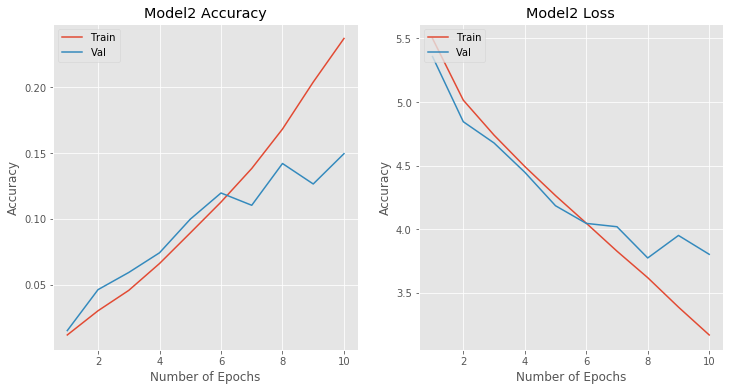

In [80]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

epoch_range = range(1, 11)

axes[0].plot(epoch_range, history1.history['accuracy'])
axes[0].plot(epoch_range, history1.history['val_accuracy'])
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Number of Epochs')
axes[0].legend(['Train', 'Val'], loc='upper left')
axes[0].set_title('Model2 Accuracy')

axes[1].plot(epoch_range, history1.history['loss'])
axes[1].plot(epoch_range, history1.history['val_loss'])
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Number of Epochs')
axes[1].legend(['Train', 'Val'], loc='upper left')
axes[1].set_title('Model2 Loss')

plt.savefig('graphs/model2_acc_loss.png')

In [83]:
# %load_ext tensorboard

# %tensorboard --logdir='logs/'

In [85]:
pred1 = model1.predict(X_test)

In [86]:
print('CNN Model 1 Prediction Check: ')
print('True label of bird: ', classes_df[classes_df['class_id'] == master_df.iloc[:y.shape[0], :]['class_id'].unique()[y_test[0].argmax()]].values)
print('Predicted label of bird: ', classes_df[classes_df['class_id'] == master_df.iloc[:y.shape[0], :]['class_id'].unique()[pred1[0].argmax()]].values)

CNN Model 1 Prediction Check: 
True label of bird:  [[963 'Common Yellowthroat (Female/immature male)']]
Predicted label of bird:  [[910 'Western Meadowlark']]


In [87]:
model1.save('saved_models/conv-3-dense-2-fr32-128.h5')
# keras.models.load_model